In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = ct.NOT_DELIVERYING_PENALTY 

## System initializer

In [3]:
def initialize_test_system(noise = False, seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = noise
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
print("States space dimension: ",toy_system.states_dim)
print("Actions space dimension: ",toy_system.actions_dim)
a_s_dim = toy_system.states_dim * toy_system.actions_dim
print("States-Actions space dimension: ",a_s_dim)

States space dimension:  36864
Actions space dimension:  36
States-Actions space dimension:  1327104


In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print("Tank max loads: ",system.tank_max_loads())
print("Tank dayly rates: ",system.tank_rates())
print("Truck max loads: ",system.truck_max_loads())
print("Graph: \n",system.graph)
print("Weights: \n", system.weights)

Tank max loads:  [100.0, 200.0, 100.0, 800.0, 200.0]
Tank dayly rates:  [16.5, 4.0, 10.500000000000002, 84.00000000000001, 34.0]
Truck max loads:  [70.0, 130.0]
Graph: 
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
Weights: 
 [[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

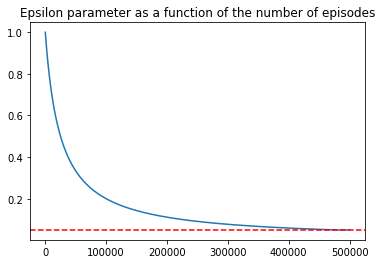

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 5*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3 #3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 218
add_noise = False

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system(noise = add_noise, seed = seed)
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

if train_epsilon == False and retrain == False:
     pass
else: # Create directories for the simulations' outputs

    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

    if not os.path.exists(simulation_directory):
        os.makedirs(simulation_directory)
        os.makedirs(simulation_directory + '/Q-dictionaries')
        os.makedirs(simulation_directory + '/discrewards')
        os.makedirs(simulation_directory + '/vis')

#     else:
#         raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")


#     ut.save_obj(toy_system, simulation_directory+"/system-sim"+"{}".format(simulation_id)) 

#     # Output headers to file
#     with open(rewards_file,'w') as f:
#          np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print("Training finished. Total episodes: {}. Elapsed time: {} minutes.".format(n_episodes,round(end_time/60., round_time)))        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
# if train_epsilon == False and retrain == False:
#     pass
# elif train_epsilon == True and retrain == False:
#     episodic_train_Q_epsilon()
# elif train_epsilon == False and retrain == True:
#     Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode_retrain))
#     episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
# else:
#     raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    

Episode: 100. Elapsed time  0.07  minuts. epsilon 0.9961 Discounted reward:  -19.654620007224004
Episode: 200. Elapsed time  0.17  minuts. epsilon 0.9921 Discounted reward:  -18.724479411744536
Episode: 300. Elapsed time  0.3  minuts. epsilon 0.9882 Discounted reward:  -18.60144222927865
Episode: 400. Elapsed time  0.43  minuts. epsilon 0.9843 Discounted reward:  -16.648862570223045
Episode: 500. Elapsed time  0.58  minuts. epsilon 0.9804 Discounted reward:  -21.679424920817382
Episode: 600. Elapsed time  0.75  minuts. epsilon 0.9766 Discounted reward:  -23.085383061108065
Episode: 700. Elapsed time  0.92  minuts. epsilon 0.9728 Discounted reward:  -22.857547712727733
Episode: 800. Elapsed time  1.12  minuts. epsilon 0.969 Discounted reward:  -21.41716862958918
Episode: 900. Elapsed time  1.31  minuts. epsilon 0.9653 Discounted reward:  -16.083923118206243
Episode: 1000. Elapsed time  1.52  minuts. epsilon 0.9616 Discounted reward:  -21.18230968992467
Episode: 1100. Elapsed time  1.73 

Episode: 8500. Elapsed time  32.95  minuts. epsilon 0.7463 Discounted reward:  -19.342819887766982
Episode: 8600. Elapsed time  33.51  minuts. epsilon 0.7441 Discounted reward:  -7.772442707424913
Episode: 8700. Elapsed time  34.05  minuts. epsilon 0.7419 Discounted reward:  -10.757935831254896
Episode: 8800. Elapsed time  34.59  minuts. epsilon 0.7397 Discounted reward:  -14.594509176321095
Episode: 8900. Elapsed time  35.14  minuts. epsilon 0.7375 Discounted reward:  -11.823600560016374
Episode: 9000. Elapsed time  35.69  minuts. epsilon 0.7353 Discounted reward:  -22.9001193460381
Episode: 9100. Elapsed time  36.25  minuts. epsilon 0.7332 Discounted reward:  -14.84687940179135
Episode: 9200. Elapsed time  36.82  minuts. epsilon 0.731 Discounted reward:  -18.500617101637253
Episode: 9300. Elapsed time  37.4  minuts. epsilon 0.7289 Discounted reward:  -16.03880676398967
Episode: 9400. Elapsed time  37.96  minuts. epsilon 0.7268 Discounted reward:  -9.062345984054485
Episode: 9500. Ela

Episode: 16800. Elapsed time  85.78  minuts. epsilon 0.5981 Discounted reward:  -9.027661502728625
Episode: 16900. Elapsed time  86.48  minuts. epsilon 0.5967 Discounted reward:  -7.555042837296147
Episode: 17000. Elapsed time  87.17  minuts. epsilon 0.5953 Discounted reward:  -16.389888924204644
Episode: 17100. Elapsed time  87.88  minuts. epsilon 0.5938 Discounted reward:  -12.196628207715827
Episode: 17200. Elapsed time  88.57  minuts. epsilon 0.5924 Discounted reward:  -11.532009869535056
Episode: 17300. Elapsed time  89.28  minuts. epsilon 0.591 Discounted reward:  -6.701890688775217
Episode: 17400. Elapsed time  89.98  minuts. epsilon 0.5896 Discounted reward:  -11.440432343922296
Episode: 17500. Elapsed time  90.77  minuts. epsilon 0.5882 Discounted reward:  -11.961586778845868
Episode: 17600. Elapsed time  91.47  minuts. epsilon 0.5869 Discounted reward:  -6.498344257240029
Episode: 17700. Elapsed time  92.18  minuts. epsilon 0.5855 Discounted reward:  -15.997345173213331
Episo

Episode: 25000. Elapsed time  147.3  minuts. epsilon 0.5 Discounted reward:  -9.590640538675121
Episode: 25100. Elapsed time  148.09  minuts. epsilon 0.499 Discounted reward:  -10.834550228972605
Episode: 25200. Elapsed time  148.88  minuts. epsilon 0.498 Discounted reward:  -9.426219748754573
Episode: 25300. Elapsed time  149.68  minuts. epsilon 0.497 Discounted reward:  -9.656318595650104
Episode: 25400. Elapsed time  150.46  minuts. epsilon 0.496 Discounted reward:  -9.856870314626475
Episode: 25500. Elapsed time  151.25  minuts. epsilon 0.4951 Discounted reward:  -12.262658176696062
Episode: 25600. Elapsed time  152.04  minuts. epsilon 0.4941 Discounted reward:  -10.851173387867522
Episode: 25700. Elapsed time  152.85  minuts. epsilon 0.4931 Discounted reward:  -5.398941671659984
Episode: 25800. Elapsed time  153.63  minuts. epsilon 0.4921 Discounted reward:  -10.33190023688872
Episode: 25900. Elapsed time  154.38  minuts. epsilon 0.4912 Discounted reward:  -7.786367277000668
Episo

Episode: 33200. Elapsed time  214.41  minuts. epsilon 0.4296 Discounted reward:  -9.514414029949597
Episode: 33300. Elapsed time  215.24  minuts. epsilon 0.4288 Discounted reward:  -4.897817032741779
Episode: 33400. Elapsed time  216.08  minuts. epsilon 0.4281 Discounted reward:  -6.668498960285486
Episode: 33500. Elapsed time  216.91  minuts. epsilon 0.4274 Discounted reward:  -13.701419292533384
Episode: 33600. Elapsed time  217.75  minuts. epsilon 0.4266 Discounted reward:  -11.717868970673528
Episode: 33700. Elapsed time  218.59  minuts. epsilon 0.4259 Discounted reward:  -10.312099511463034
Episode: 33800. Elapsed time  219.44  minuts. epsilon 0.4252 Discounted reward:  -9.893870891674268
Episode: 33900. Elapsed time  220.31  minuts. epsilon 0.4245 Discounted reward:  -8.716880994501892
Episode: 34000. Elapsed time  221.15  minuts. epsilon 0.4237 Discounted reward:  -9.394679719256565
Episode: 34100. Elapsed time  221.98  minuts. epsilon 0.423 Discounted reward:  -12.4023712669034

Episode: 41400. Elapsed time  285.24  minuts. epsilon 0.3765 Discounted reward:  -7.549548068036758
Episode: 41500. Elapsed time  286.15  minuts. epsilon 0.3759 Discounted reward:  -2.4662637648380272
Episode: 41600. Elapsed time  287.02  minuts. epsilon 0.3754 Discounted reward:  -7.692111120724219
Episode: 41700. Elapsed time  287.94  minuts. epsilon 0.3748 Discounted reward:  -9.823541891478179
Episode: 41800. Elapsed time  288.83  minuts. epsilon 0.3743 Discounted reward:  -5.8161717439635305
Episode: 41900. Elapsed time  289.7  minuts. epsilon 0.3737 Discounted reward:  -4.968193832086132
Episode: 42000. Elapsed time  290.57  minuts. epsilon 0.3731 Discounted reward:  -8.49044967635292
Episode: 42100. Elapsed time  291.46  minuts. epsilon 0.3726 Discounted reward:  -4.938138994690595
Episode: 42200. Elapsed time  292.35  minuts. epsilon 0.372 Discounted reward:  -5.370281768620943
Episode: 42300. Elapsed time  293.23  minuts. epsilon 0.3715 Discounted reward:  -2.1561692113530806


Episode: 49600. Elapsed time  358.37  minuts. epsilon 0.3351 Discounted reward:  -7.467490744544615
Episode: 49700. Elapsed time  359.28  minuts. epsilon 0.3347 Discounted reward:  -5.751215607094985
Episode: 49800. Elapsed time  360.29  minuts. epsilon 0.3342 Discounted reward:  -6.031614812292913
Episode: 49900. Elapsed time  361.31  minuts. epsilon 0.3338 Discounted reward:  -3.948351295129406
Episode: 50000. Elapsed time  362.31  minuts. epsilon 0.3333 Discounted reward:  -5.493782530983294
Episode: 50100. Elapsed time  363.32  minuts. epsilon 0.3329 Discounted reward:  -11.243670517994325
Episode: 50200. Elapsed time  364.25  minuts. epsilon 0.3325 Discounted reward:  -7.1746101138449045
Episode: 50300. Elapsed time  365.15  minuts. epsilon 0.332 Discounted reward:  -10.499507583132553
Episode: 50400. Elapsed time  366.06  minuts. epsilon 0.3316 Discounted reward:  -6.543144370658782
Episode: 50500. Elapsed time  366.98  minuts. epsilon 0.3311 Discounted reward:  -6.05102919158467

Episode: 57800. Elapsed time  435.45  minuts. epsilon 0.3019 Discounted reward:  -4.04057811066691
Episode: 57900. Elapsed time  436.5  minuts. epsilon 0.3016 Discounted reward:  -8.13906463815267
Episode: 58000. Elapsed time  437.47  minuts. epsilon 0.3012 Discounted reward:  -8.854185507323697
Episode: 58100. Elapsed time  438.4  minuts. epsilon 0.3008 Discounted reward:  -5.883117585163429
Episode: 58200. Elapsed time  439.35  minuts. epsilon 0.3005 Discounted reward:  -10.973951092242778
Episode: 58300. Elapsed time  440.27  minuts. epsilon 0.3001 Discounted reward:  -2.2573702361369214
Episode: 58400. Elapsed time  441.2  minuts. epsilon 0.2998 Discounted reward:  -3.400073830545772
Episode: 58500. Elapsed time  442.16  minuts. epsilon 0.2994 Discounted reward:  -3.274252056715828
Episode: 58600. Elapsed time  443.08  minuts. epsilon 0.299 Discounted reward:  -5.592842113932753
Episode: 58700. Elapsed time  444.02  minuts. epsilon 0.2987 Discounted reward:  -6.311794602129347
Epis

Episode: 66000. Elapsed time  514.09  minuts. epsilon 0.2747 Discounted reward:  -2.3488772139706824
Episode: 66100. Elapsed time  515.07  minuts. epsilon 0.2744 Discounted reward:  -6.689455793550346
Episode: 66200. Elapsed time  516.01  minuts. epsilon 0.2741 Discounted reward:  -4.7889375571813195
Episode: 66300. Elapsed time  516.95  minuts. epsilon 0.2738 Discounted reward:  -2.579481358790981
Episode: 66400. Elapsed time  517.9  minuts. epsilon 0.2735 Discounted reward:  -5.741715540900047
Episode: 66500. Elapsed time  518.85  minuts. epsilon 0.2732 Discounted reward:  -8.386674590844843
Episode: 66600. Elapsed time  519.88  minuts. epsilon 0.2729 Discounted reward:  -3.893651671313337
Episode: 66700. Elapsed time  520.9  minuts. epsilon 0.2726 Discounted reward:  -2.6383498514182095
Episode: 66800. Elapsed time  521.92  minuts. epsilon 0.2723 Discounted reward:  -2.8113171614844847
Episode: 66900. Elapsed time  522.94  minuts. epsilon 0.272 Discounted reward:  -7.727329885048009

Episode: 74200. Elapsed time  593.86  minuts. epsilon 0.252 Discounted reward:  -4.5725842112539
Episode: 74300. Elapsed time  594.84  minuts. epsilon 0.2518 Discounted reward:  -6.32340503570273
Episode: 74400. Elapsed time  595.83  minuts. epsilon 0.2515 Discounted reward:  -6.078802255249692
Episode: 74500. Elapsed time  596.79  minuts. epsilon 0.2513 Discounted reward:  -5.150736612570148
Episode: 74600. Elapsed time  597.75  minuts. epsilon 0.251 Discounted reward:  -8.34520900664802
Episode: 74700. Elapsed time  598.72  minuts. epsilon 0.2508 Discounted reward:  -5.64959324767082
Episode: 74800. Elapsed time  599.68  minuts. epsilon 0.2505 Discounted reward:  -6.293806332930756
Episode: 74900. Elapsed time  600.65  minuts. epsilon 0.2503 Discounted reward:  -4.756594987936826
Episode: 75000. Elapsed time  601.6  minuts. epsilon 0.25 Discounted reward:  -0.9531414999856723
Episode: 75100. Elapsed time  602.58  minuts. epsilon 0.2498 Discounted reward:  -2.803674694267057
Episode: 

Episode: 82400. Elapsed time  674.36  minuts. epsilon 0.2328 Discounted reward:  -1.9329410335233175
Episode: 82500. Elapsed time  675.34  minuts. epsilon 0.2326 Discounted reward:  -1.5258031164620232
Episode: 82600. Elapsed time  676.31  minuts. epsilon 0.2323 Discounted reward:  -12.974897433710279
Episode: 82700. Elapsed time  677.31  minuts. epsilon 0.2321 Discounted reward:  -2.7888244939408118
Episode: 82800. Elapsed time  678.31  minuts. epsilon 0.2319 Discounted reward:  -2.556314125531458
Episode: 82900. Elapsed time  679.29  minuts. epsilon 0.2317 Discounted reward:  -2.7417707903934563
Episode: 83000. Elapsed time  680.27  minuts. epsilon 0.2315 Discounted reward:  -1.2636476636549105
Episode: 83100. Elapsed time  681.26  minuts. epsilon 0.2313 Discounted reward:  -5.185467949260933
Episode: 83200. Elapsed time  682.25  minuts. epsilon 0.2311 Discounted reward:  -11.627362753971116
Episode: 83300. Elapsed time  683.24  minuts. epsilon 0.2308 Discounted reward:  -3.737472991

Episode: 90600. Elapsed time  755.56  minuts. epsilon 0.2163 Discounted reward:  -2.764577058231144
Episode: 90700. Elapsed time  756.53  minuts. epsilon 0.2161 Discounted reward:  -5.643534054398375
Episode: 90800. Elapsed time  757.55  minuts. epsilon 0.2159 Discounted reward:  -2.6916787494193195
Episode: 90900. Elapsed time  758.54  minuts. epsilon 0.2157 Discounted reward:  -4.324449242992469
Episode: 91000. Elapsed time  759.56  minuts. epsilon 0.2155 Discounted reward:  -2.577703344105263
Episode: 91100. Elapsed time  760.57  minuts. epsilon 0.2153 Discounted reward:  -5.786453790685474
Episode: 91200. Elapsed time  761.57  minuts. epsilon 0.2151 Discounted reward:  -3.006902449556373
Episode: 91300. Elapsed time  762.57  minuts. epsilon 0.215 Discounted reward:  -4.91274384368942
Episode: 91400. Elapsed time  763.57  minuts. epsilon 0.2148 Discounted reward:  -5.871084837621198
Episode: 91500. Elapsed time  764.55  minuts. epsilon 0.2146 Discounted reward:  -5.884136942316142
E

Episode: 98800. Elapsed time  837.96  minuts. epsilon 0.2019 Discounted reward:  -4.173866743714205
Episode: 98900. Elapsed time  839.0  minuts. epsilon 0.2018 Discounted reward:  -5.6162055397318715
Episode: 99000. Elapsed time  840.02  minuts. epsilon 0.2016 Discounted reward:  -6.274067427998349
Episode: 99100. Elapsed time  841.05  minuts. epsilon 0.2015 Discounted reward:  -6.8760882884641585
Episode: 99200. Elapsed time  842.07  minuts. epsilon 0.2013 Discounted reward:  -8.290480974378307
Episode: 99300. Elapsed time  843.08  minuts. epsilon 0.2011 Discounted reward:  -4.595943688765971
Episode: 99400. Elapsed time  844.09  minuts. epsilon 0.201 Discounted reward:  -1.9602181205162315
Episode: 99500. Elapsed time  845.1  minuts. epsilon 0.2008 Discounted reward:  -6.141518505502296
Episode: 99600. Elapsed time  846.12  minuts. epsilon 0.2006 Discounted reward:  -3.688187308159556
Episode: 99700. Elapsed time  847.14  minuts. epsilon 0.2005 Discounted reward:  -3.8785728557579238

Episode: 107000. Elapsed time  921.39  minuts. epsilon 0.1894 Discounted reward:  -3.157751557250602
Episode: 107100. Elapsed time  922.41  minuts. epsilon 0.1893 Discounted reward:  -7.581224928115852
Episode: 107200. Elapsed time  923.41  minuts. epsilon 0.1891 Discounted reward:  -3.564920728730644
Episode: 107300. Elapsed time  924.44  minuts. epsilon 0.189 Discounted reward:  -5.676042951136037
Episode: 107400. Elapsed time  925.45  minuts. epsilon 0.1888 Discounted reward:  -2.561833514441273
Episode: 107500. Elapsed time  926.47  minuts. epsilon 0.1887 Discounted reward:  -3.9069026896332617
Episode: 107600. Elapsed time  927.48  minuts. epsilon 0.1885 Discounted reward:  -2.8296417401445333
Episode: 107700. Elapsed time  928.52  minuts. epsilon 0.1884 Discounted reward:  -1.227861839668476
Episode: 107800. Elapsed time  929.52  minuts. epsilon 0.1883 Discounted reward:  -8.331751466061746
Episode: 107900. Elapsed time  930.53  minuts. epsilon 0.1881 Discounted reward:  -1.53087

Episode: 115100. Elapsed time  1004.29  minuts. epsilon 0.1784 Discounted reward:  -3.757217168971689
Episode: 115200. Elapsed time  1005.31  minuts. epsilon 0.1783 Discounted reward:  -6.032629579062809
Episode: 115300. Elapsed time  1006.34  minuts. epsilon 0.1782 Discounted reward:  -4.403810144829398
Episode: 115400. Elapsed time  1007.37  minuts. epsilon 0.1781 Discounted reward:  -3.719259699673768
Episode: 115500. Elapsed time  1008.4  minuts. epsilon 0.1779 Discounted reward:  -6.560729198354535
Episode: 115600. Elapsed time  1009.42  minuts. epsilon 0.1778 Discounted reward:  -2.739764137681345
Episode: 115700. Elapsed time  1010.45  minuts. epsilon 0.1777 Discounted reward:  -5.573262833985141
Episode: 115800. Elapsed time  1011.49  minuts. epsilon 0.1776 Discounted reward:  -2.6059421735016883
Episode: 115900. Elapsed time  1012.54  minuts. epsilon 0.1774 Discounted reward:  -3.976871797314739
Episode: 116000. Elapsed time  1013.56  minuts. epsilon 0.1773 Discounted reward: 

Episode: 123200. Elapsed time  1087.79  minuts. epsilon 0.1687 Discounted reward:  -1.743884126139373
Episode: 123300. Elapsed time  1088.85  minuts. epsilon 0.1686 Discounted reward:  -2.0515271249720635
Episode: 123400. Elapsed time  1089.88  minuts. epsilon 0.1685 Discounted reward:  -2.4795225257615328
Episode: 123500. Elapsed time  1090.91  minuts. epsilon 0.1684 Discounted reward:  -3.568288912116463
Episode: 123600. Elapsed time  1091.94  minuts. epsilon 0.1682 Discounted reward:  -5.745909065626064
Episode: 123700. Elapsed time  1092.96  minuts. epsilon 0.1681 Discounted reward:  -5.3677903637074955
Episode: 123800. Elapsed time  1093.98  minuts. epsilon 0.168 Discounted reward:  -3.165966897664018
Episode: 123900. Elapsed time  1095.02  minuts. epsilon 0.1679 Discounted reward:  -10.072361241178193
Episode: 124000. Elapsed time  1096.06  minuts. epsilon 0.1678 Discounted reward:  -1.855679048880425
Episode: 124100. Elapsed time  1097.09  minuts. epsilon 0.1677 Discounted rewar

Episode: 131300. Elapsed time  1171.74  minuts. epsilon 0.1599 Discounted reward:  -2.0452236797702112
Episode: 131400. Elapsed time  1172.77  minuts. epsilon 0.1598 Discounted reward:  -4.306396943802594
Episode: 131500. Elapsed time  1173.82  minuts. epsilon 0.1597 Discounted reward:  -2.586317512438198
Episode: 131600. Elapsed time  1174.87  minuts. epsilon 0.1596 Discounted reward:  -4.033650486267448
Episode: 131700. Elapsed time  1175.92  minuts. epsilon 0.1595 Discounted reward:  -2.5479463314405106
Episode: 131800. Elapsed time  1176.96  minuts. epsilon 0.1594 Discounted reward:  -1.757809969211252
Episode: 131900. Elapsed time  1177.99  minuts. epsilon 0.1593 Discounted reward:  -4.31932487743613
Episode: 132000. Elapsed time  1178.99  minuts. epsilon 0.1592 Discounted reward:  -4.321719138917936
Episode: 132100. Elapsed time  1180.03  minuts. epsilon 0.1591 Discounted reward:  -1.90692659501834
Episode: 132200. Elapsed time  1181.08  minuts. epsilon 0.159 Discounted reward:  

Episode: 139300. Elapsed time  1254.26  minuts. epsilon 0.1522 Discounted reward:  -4.78803644746528
Episode: 139400. Elapsed time  1255.36  minuts. epsilon 0.1521 Discounted reward:  -8.530743831955828
Episode: 139500. Elapsed time  1256.58  minuts. epsilon 0.152 Discounted reward:  -5.806335465897258
Episode: 139600. Elapsed time  1257.63  minuts. epsilon 0.1519 Discounted reward:  -1.7640661473856847
Episode: 139700. Elapsed time  1258.64  minuts. epsilon 0.1518 Discounted reward:  -2.5013164474886516
Episode: 139800. Elapsed time  1259.7  minuts. epsilon 0.1517 Discounted reward:  -1.9642287272407408
Episode: 139900. Elapsed time  1260.73  minuts. epsilon 0.1516 Discounted reward:  -1.276357184438633
Episode: 140000. Elapsed time  1261.75  minuts. epsilon 0.1515 Discounted reward:  -5.728035061741109
Episode: 140100. Elapsed time  1262.79  minuts. epsilon 0.1514 Discounted reward:  -5.189821828152228
Episode: 140200. Elapsed time  1263.85  minuts. epsilon 0.1513 Discounted reward: 

Episode: 147400. Elapsed time  1338.45  minuts. epsilon 0.145 Discounted reward:  -3.5635538259537958
Episode: 147500. Elapsed time  1339.44  minuts. epsilon 0.1449 Discounted reward:  -2.7758553112977475
Episode: 147600. Elapsed time  1340.7  minuts. epsilon 0.1448 Discounted reward:  -1.6797162060601802
Episode: 147700. Elapsed time  1341.75  minuts. epsilon 0.1448 Discounted reward:  -2.5294544521943765
Episode: 147800. Elapsed time  1342.81  minuts. epsilon 0.1447 Discounted reward:  -5.617243490437754
Episode: 147900. Elapsed time  1343.85  minuts. epsilon 0.1446 Discounted reward:  -1.9712746563757275
Episode: 148000. Elapsed time  1344.87  minuts. epsilon 0.1445 Discounted reward:  -2.2116385498804205
Episode: 148100. Elapsed time  1345.89  minuts. epsilon 0.1444 Discounted reward:  -3.6503541028183215
Episode: 148200. Elapsed time  1346.92  minuts. epsilon 0.1443 Discounted reward:  -2.6611825429635587
Episode: 148300. Elapsed time  1347.95  minuts. epsilon 0.1443 Discounted re

Episode: 155400. Elapsed time  1421.81  minuts. epsilon 0.1386 Discounted reward:  -0.8669525192506448
Episode: 155500. Elapsed time  1422.74  minuts. epsilon 0.1385 Discounted reward:  -1.9376656075093581
Episode: 155600. Elapsed time  1423.68  minuts. epsilon 0.1384 Discounted reward:  -4.270355530567243
Episode: 155700. Elapsed time  1424.63  minuts. epsilon 0.1384 Discounted reward:  -1.465676564517441
Episode: 155800. Elapsed time  1425.55  minuts. epsilon 0.1383 Discounted reward:  -5.744012096269271
Episode: 155900. Elapsed time  1426.48  minuts. epsilon 0.1382 Discounted reward:  -5.017167454080076
Episode: 156000. Elapsed time  1427.41  minuts. epsilon 0.1381 Discounted reward:  -3.8470722354423996
Episode: 156100. Elapsed time  1428.39  minuts. epsilon 0.138 Discounted reward:  -6.748976016364577
Episode: 156200. Elapsed time  1429.35  minuts. epsilon 0.138 Discounted reward:  -0.9514176906833154
Episode: 156300. Elapsed time  1430.3  minuts. epsilon 0.1379 Discounted reward:

Episode: 163400. Elapsed time  1497.33  minuts. epsilon 0.1327 Discounted reward:  -4.0727555671658555
Episode: 163500. Elapsed time  1498.36  minuts. epsilon 0.1326 Discounted reward:  -1.5745476073622526
Episode: 163600. Elapsed time  1499.41  minuts. epsilon 0.1326 Discounted reward:  -3.4812555236685574
Episode: 163700. Elapsed time  1500.44  minuts. epsilon 0.1325 Discounted reward:  -9.28522644862824
Episode: 163800. Elapsed time  1501.49  minuts. epsilon 0.1324 Discounted reward:  -3.013994494372589
Episode: 163900. Elapsed time  1502.51  minuts. epsilon 0.1323 Discounted reward:  -1.591117847528816
Episode: 164000. Elapsed time  1503.55  minuts. epsilon 0.1323 Discounted reward:  -0.7516666934687732
Episode: 164100. Elapsed time  1505.31  minuts. epsilon 0.1322 Discounted reward:  -3.589553563776102
Episode: 164200. Elapsed time  1507.42  minuts. epsilon 0.1321 Discounted reward:  -1.589485107140608
Episode: 164300. Elapsed time  1509.54  minuts. epsilon 0.1321 Discounted rewar

Episode: 171400. Elapsed time  1609.44  minuts. epsilon 0.1273 Discounted reward:  -5.976023602920904
Episode: 171500. Elapsed time  1610.84  minuts. epsilon 0.1272 Discounted reward:  -3.9229681299672357
Episode: 171600. Elapsed time  1611.93  minuts. epsilon 0.1272 Discounted reward:  -3.8285393297141734
Episode: 171700. Elapsed time  1613.89  minuts. epsilon 0.1271 Discounted reward:  -1.1037923018393552
Episode: 171800. Elapsed time  1616.07  minuts. epsilon 0.127 Discounted reward:  -3.0458170118557133
Episode: 171900. Elapsed time  1618.24  minuts. epsilon 0.127 Discounted reward:  -0.921630743412861
Episode: 172000. Elapsed time  1620.4  minuts. epsilon 0.1269 Discounted reward:  -6.176599719863775
Episode: 172100. Elapsed time  1622.56  minuts. epsilon 0.1268 Discounted reward:  -4.119942733250732
Episode: 172200. Elapsed time  1624.72  minuts. epsilon 0.1268 Discounted reward:  -2.316818762752234
Episode: 172300. Elapsed time  1626.86  minuts. epsilon 0.1267 Discounted reward:

Episode: 179400. Elapsed time  1706.4  minuts. epsilon 0.1223 Discounted reward:  -2.5811033075301806
Episode: 179500. Elapsed time  1707.48  minuts. epsilon 0.1222 Discounted reward:  -4.783976597617136
Episode: 179600. Elapsed time  1708.58  minuts. epsilon 0.1222 Discounted reward:  -1.3082975207794094
Episode: 179700. Elapsed time  1709.66  minuts. epsilon 0.1221 Discounted reward:  -3.9914481716659003
Episode: 179800. Elapsed time  1710.73  minuts. epsilon 0.1221 Discounted reward:  -2.7479377022859843
Episode: 179900. Elapsed time  1711.82  minuts. epsilon 0.122 Discounted reward:  -1.173284984596764
Episode: 180000. Elapsed time  1712.9  minuts. epsilon 0.122 Discounted reward:  -1.6769174745719722
Episode: 180100. Elapsed time  1713.98  minuts. epsilon 0.1219 Discounted reward:  -3.5800925722662953
Episode: 180200. Elapsed time  1715.05  minuts. epsilon 0.1218 Discounted reward:  -1.6264779575283739
Episode: 180300. Elapsed time  1716.12  minuts. epsilon 0.1218 Discounted rewar

Episode: 187500. Elapsed time  1794.59  minuts. epsilon 0.1176 Discounted reward:  -1.7178088009006718
Episode: 187600. Elapsed time  1795.66  minuts. epsilon 0.1176 Discounted reward:  -1.1520047675166853
Episode: 187700. Elapsed time  1796.73  minuts. epsilon 0.1175 Discounted reward:  -2.4311611422406925
Episode: 187800. Elapsed time  1797.79  minuts. epsilon 0.1175 Discounted reward:  -4.204199554431732
Episode: 187900. Elapsed time  1798.87  minuts. epsilon 0.1174 Discounted reward:  -0.7893240053554358
Episode: 188000. Elapsed time  1799.96  minuts. epsilon 0.1174 Discounted reward:  -4.029427594468513
Episode: 188100. Elapsed time  1801.03  minuts. epsilon 0.1173 Discounted reward:  -3.3054116920011447
Episode: 188200. Elapsed time  1802.09  minuts. epsilon 0.1173 Discounted reward:  -1.2964837205621718
Episode: 188300. Elapsed time  1803.12  minuts. epsilon 0.1172 Discounted reward:  -2.7420853053290877
Episode: 188400. Elapsed time  1804.22  minuts. epsilon 0.1172 Discounted r

Episode: 195500. Elapsed time  1880.37  minuts. epsilon 0.1134 Discounted reward:  -1.68230358919593
Episode: 195600. Elapsed time  1882.47  minuts. epsilon 0.1133 Discounted reward:  -0.81448409286865
Episode: 195700. Elapsed time  1884.52  minuts. epsilon 0.1133 Discounted reward:  -1.3492272366697289
Episode: 195800. Elapsed time  1886.62  minuts. epsilon 0.1132 Discounted reward:  -4.234958766056546
Episode: 195900. Elapsed time  1888.71  minuts. epsilon 0.1132 Discounted reward:  -3.2866109782569395
Episode: 196000. Elapsed time  1890.81  minuts. epsilon 0.1131 Discounted reward:  -3.3151101420780726
Episode: 196100. Elapsed time  1892.88  minuts. epsilon 0.1131 Discounted reward:  -2.126533903032603
Episode: 196200. Elapsed time  1894.95  minuts. epsilon 0.113 Discounted reward:  -0.7274367325952298
Episode: 196300. Elapsed time  1897.04  minuts. epsilon 0.113 Discounted reward:  -5.207194239134423
Episode: 196400. Elapsed time  1899.11  minuts. epsilon 0.1129 Discounted reward: 

Episode: 203500. Elapsed time  1987.52  minuts. epsilon 0.1094 Discounted reward:  -2.2254367276139693
Episode: 203600. Elapsed time  1988.59  minuts. epsilon 0.1094 Discounted reward:  -3.4964711928794503
Episode: 203700. Elapsed time  1989.77  minuts. epsilon 0.1093 Discounted reward:  -2.1097582509320376
Episode: 203800. Elapsed time  1990.94  minuts. epsilon 0.1093 Discounted reward:  -4.826925413362505
Episode: 203900. Elapsed time  1992.0  minuts. epsilon 0.1092 Discounted reward:  -2.3640664911131823
Episode: 204000. Elapsed time  1993.07  minuts. epsilon 0.1092 Discounted reward:  -2.803743677440258
Episode: 204100. Elapsed time  1994.14  minuts. epsilon 0.1091 Discounted reward:  -1.0318015592359193
Episode: 204200. Elapsed time  1995.27  minuts. epsilon 0.1091 Discounted reward:  -4.312921825262917
Episode: 204300. Elapsed time  1996.44  minuts. epsilon 0.109 Discounted reward:  -2.5783679436024793
Episode: 204400. Elapsed time  1997.6  minuts. epsilon 0.109 Discounted reward

Episode: 211500. Elapsed time  2076.63  minuts. epsilon 0.1057 Discounted reward:  -1.6498630217538532
Episode: 211600. Elapsed time  2077.7  minuts. epsilon 0.1057 Discounted reward:  -0.8956759237511354
Episode: 211700. Elapsed time  2078.75  minuts. epsilon 0.1056 Discounted reward:  -2.3513635680051546
Episode: 211800. Elapsed time  2079.8  minuts. epsilon 0.1056 Discounted reward:  -5.25683582004745
Episode: 211900. Elapsed time  2080.89  minuts. epsilon 0.1055 Discounted reward:  -1.9773451786591503
Episode: 212000. Elapsed time  2081.95  minuts. epsilon 0.1055 Discounted reward:  -4.2044117775833865
Episode: 212100. Elapsed time  2083.02  minuts. epsilon 0.1054 Discounted reward:  -3.93512626537977
Episode: 212200. Elapsed time  2084.08  minuts. epsilon 0.1054 Discounted reward:  -4.000832033442065
Episode: 212300. Elapsed time  2085.14  minuts. epsilon 0.1054 Discounted reward:  -2.8457886994938892
Episode: 212400. Elapsed time  2086.21  minuts. epsilon 0.1053 Discounted reward

Episode: 219500. Elapsed time  2163.18  minuts. epsilon 0.1022 Discounted reward:  -1.909522228579527
Episode: 219600. Elapsed time  2164.26  minuts. epsilon 0.1022 Discounted reward:  -2.7183870796238083
Episode: 219700. Elapsed time  2165.32  minuts. epsilon 0.1022 Discounted reward:  -2.491515664322625
Episode: 219800. Elapsed time  2166.4  minuts. epsilon 0.1021 Discounted reward:  -3.923745741621659
Episode: 219900. Elapsed time  2167.46  minuts. epsilon 0.1021 Discounted reward:  -1.5029932102355072
Episode: 220000. Elapsed time  2168.53  minuts. epsilon 0.102 Discounted reward:  -2.1959005385231807
Episode: 220100. Elapsed time  2169.6  minuts. epsilon 0.102 Discounted reward:  -4.026774577429623
Episode: 220200. Elapsed time  2170.67  minuts. epsilon 0.102 Discounted reward:  -4.5203198960158355
Episode: 220300. Elapsed time  2171.73  minuts. epsilon 0.1019 Discounted reward:  -3.968019351763659
Episode: 220400. Elapsed time  2172.81  minuts. epsilon 0.1019 Discounted reward:  

Episode: 227500. Elapsed time  2250.47  minuts. epsilon 0.099 Discounted reward:  -0.9702903014793216
Episode: 227600. Elapsed time  2251.56  minuts. epsilon 0.099 Discounted reward:  -0.997630776219171
Episode: 227700. Elapsed time  2252.65  minuts. epsilon 0.0989 Discounted reward:  -1.4635827496787213
Episode: 227800. Elapsed time  2253.74  minuts. epsilon 0.0989 Discounted reward:  -3.533279869119641
Episode: 227900. Elapsed time  2254.85  minuts. epsilon 0.0989 Discounted reward:  -4.196792385045507
Episode: 228000. Elapsed time  2255.95  minuts. epsilon 0.0988 Discounted reward:  -2.2179790546909572
Episode: 228100. Elapsed time  2257.04  minuts. epsilon 0.0988 Discounted reward:  -3.1029486661709877
Episode: 228200. Elapsed time  2258.15  minuts. epsilon 0.0987 Discounted reward:  -2.227549948202581
Episode: 228300. Elapsed time  2259.27  minuts. epsilon 0.0987 Discounted reward:  -1.0948126947168466
Episode: 228400. Elapsed time  2260.38  minuts. epsilon 0.0987 Discounted rewar

Episode: 235500. Elapsed time  2338.8  minuts. epsilon 0.096 Discounted reward:  -5.33217497741534
Episode: 235600. Elapsed time  2340.01  minuts. epsilon 0.0959 Discounted reward:  -5.530529394233163
Episode: 235700. Elapsed time  2341.12  minuts. epsilon 0.0959 Discounted reward:  -5.549699656379572
Episode: 235800. Elapsed time  2342.21  minuts. epsilon 0.0959 Discounted reward:  -4.157871608038163
Episode: 235900. Elapsed time  2343.31  minuts. epsilon 0.0958 Discounted reward:  -3.0300338973068057
Episode: 236000. Elapsed time  2344.42  minuts. epsilon 0.0958 Discounted reward:  -1.8844988360627108
Episode: 236100. Elapsed time  2345.53  minuts. epsilon 0.0957 Discounted reward:  -1.2680727044358513
Episode: 236200. Elapsed time  2346.63  minuts. epsilon 0.0957 Discounted reward:  -1.429924005295429
Episode: 236300. Elapsed time  2347.73  minuts. epsilon 0.0957 Discounted reward:  -2.040866347744978
Episode: 236400. Elapsed time  2348.83  minuts. epsilon 0.0956 Discounted reward: 

Episode: 243500. Elapsed time  2427.46  minuts. epsilon 0.0931 Discounted reward:  -3.1671203390967366
Episode: 243600. Elapsed time  2428.55  minuts. epsilon 0.0931 Discounted reward:  -2.3713362794661914
Episode: 243700. Elapsed time  2429.65  minuts. epsilon 0.093 Discounted reward:  -5.467729740437875
Episode: 243800. Elapsed time  2430.77  minuts. epsilon 0.093 Discounted reward:  -0.9472306424603187
Episode: 243900. Elapsed time  2431.86  minuts. epsilon 0.093 Discounted reward:  -1.0207229663907103
Episode: 244000. Elapsed time  2432.95  minuts. epsilon 0.0929 Discounted reward:  -1.1889948168504312
Episode: 244100. Elapsed time  2434.06  minuts. epsilon 0.0929 Discounted reward:  -7.488303221528553
Episode: 244200. Elapsed time  2435.18  minuts. epsilon 0.0929 Discounted reward:  -3.378433682485576
Episode: 244300. Elapsed time  2436.29  minuts. epsilon 0.0928 Discounted reward:  -2.712251366032464
Episode: 244400. Elapsed time  2437.42  minuts. epsilon 0.0928 Discounted reward

Episode: 251500. Elapsed time  2516.42  minuts. epsilon 0.0904 Discounted reward:  -1.1827612518411004
Episode: 251600. Elapsed time  2517.52  minuts. epsilon 0.0904 Discounted reward:  -1.225240253505906
Episode: 251700. Elapsed time  2518.64  minuts. epsilon 0.0904 Discounted reward:  -1.9744909066608938
Episode: 251800. Elapsed time  2519.74  minuts. epsilon 0.0903 Discounted reward:  -1.404906531187705
Episode: 251900. Elapsed time  2520.84  minuts. epsilon 0.0903 Discounted reward:  -0.99955109234663
Episode: 252000. Elapsed time  2521.94  minuts. epsilon 0.0903 Discounted reward:  -1.4425594639079997
Episode: 252100. Elapsed time  2523.05  minuts. epsilon 0.0902 Discounted reward:  -1.7526885575699604
Episode: 252200. Elapsed time  2524.16  minuts. epsilon 0.0902 Discounted reward:  -1.0489446202337662
Episode: 252300. Elapsed time  2525.27  minuts. epsilon 0.0902 Discounted reward:  -1.7252239257074073
Episode: 252400. Elapsed time  2526.38  minuts. epsilon 0.0901 Discounted rew

Episode: 259500. Elapsed time  2605.44  minuts. epsilon 0.0879 Discounted reward:  -3.8987981028265524
Episode: 259600. Elapsed time  2606.55  minuts. epsilon 0.0878 Discounted reward:  -2.3142540548455597
Episode: 259700. Elapsed time  2607.64  minuts. epsilon 0.0878 Discounted reward:  -0.7732425298733719
Episode: 259800. Elapsed time  2608.76  minuts. epsilon 0.0878 Discounted reward:  -2.7034210726628327
Episode: 259900. Elapsed time  2609.86  minuts. epsilon 0.0878 Discounted reward:  -1.4850741258332218
Episode: 260000. Elapsed time  2610.95  minuts. epsilon 0.0877 Discounted reward:  -1.4271704110562051
Episode: 260100. Elapsed time  2612.04  minuts. epsilon 0.0877 Discounted reward:  -3.410962094339604
Episode: 260200. Elapsed time  2613.31  minuts. epsilon 0.0877 Discounted reward:  -2.88823464070543
Episode: 260300. Elapsed time  2614.41  minuts. epsilon 0.0876 Discounted reward:  -3.0075991661632897
Episode: 260400. Elapsed time  2615.51  minuts. epsilon 0.0876 Discounted re

Episode: 267500. Elapsed time  2694.3  minuts. epsilon 0.0855 Discounted reward:  -0.6062466613836294
Episode: 267600. Elapsed time  2695.42  minuts. epsilon 0.0854 Discounted reward:  -2.62176741252375
Episode: 267700. Elapsed time  2696.53  minuts. epsilon 0.0854 Discounted reward:  -1.391886258090222
Episode: 267800. Elapsed time  2697.63  minuts. epsilon 0.0854 Discounted reward:  -1.8612391938207258
Episode: 267900. Elapsed time  2698.74  minuts. epsilon 0.0854 Discounted reward:  -3.5285218904996083
Episode: 268000. Elapsed time  2699.82  minuts. epsilon 0.0853 Discounted reward:  -1.5956024675617462
Episode: 268100. Elapsed time  2700.96  minuts. epsilon 0.0853 Discounted reward:  -0.9395953295307595
Episode: 268200. Elapsed time  2702.17  minuts. epsilon 0.0853 Discounted reward:  -1.4042412258018586
Episode: 268300. Elapsed time  2703.28  minuts. epsilon 0.0852 Discounted reward:  -1.71991975784662
Episode: 268400. Elapsed time  2704.4  minuts. epsilon 0.0852 Discounted reward

Episode: 275500. Elapsed time  2783.73  minuts. epsilon 0.0832 Discounted reward:  -1.5004074440852369
Episode: 275600. Elapsed time  2784.86  minuts. epsilon 0.0832 Discounted reward:  -2.3335917663236567
Episode: 275700. Elapsed time  2785.99  minuts. epsilon 0.0831 Discounted reward:  -1.736188539661991
Episode: 275800. Elapsed time  2787.11  minuts. epsilon 0.0831 Discounted reward:  -1.994397870410543
Episode: 275900. Elapsed time  2788.23  minuts. epsilon 0.0831 Discounted reward:  -0.926471243234902
Episode: 276000. Elapsed time  2789.35  minuts. epsilon 0.0831 Discounted reward:  -1.3190047853410314
Episode: 276100. Elapsed time  2790.48  minuts. epsilon 0.083 Discounted reward:  -6.565583214643907
Episode: 276200. Elapsed time  2791.59  minuts. epsilon 0.083 Discounted reward:  -2.714019870700864
Episode: 276300. Elapsed time  2792.71  minuts. epsilon 0.083 Discounted reward:  -3.1086837900434774
Episode: 276400. Elapsed time  2793.82  minuts. epsilon 0.0829 Discounted reward:

Episode: 283500. Elapsed time  2873.26  minuts. epsilon 0.081 Discounted reward:  -3.56285800554259
Episode: 283600. Elapsed time  2874.52  minuts. epsilon 0.081 Discounted reward:  -2.0038114050884626
Episode: 283700. Elapsed time  2875.64  minuts. epsilon 0.081 Discounted reward:  -3.0573112060247607
Episode: 283800. Elapsed time  2876.77  minuts. epsilon 0.081 Discounted reward:  -1.570739264518578
Episode: 283900. Elapsed time  2877.89  minuts. epsilon 0.0809 Discounted reward:  -2.6424413748159195
Episode: 284000. Elapsed time  2879.01  minuts. epsilon 0.0809 Discounted reward:  -0.8557898751133871
Episode: 284100. Elapsed time  2880.15  minuts. epsilon 0.0809 Discounted reward:  -2.287712992402379
Episode: 284200. Elapsed time  2881.27  minuts. epsilon 0.0809 Discounted reward:  -3.736152180675541
Episode: 284300. Elapsed time  2882.38  minuts. epsilon 0.0808 Discounted reward:  -1.666948222362186
Episode: 284400. Elapsed time  2883.49  minuts. epsilon 0.0808 Discounted reward:  

Episode: 291500. Elapsed time  2963.77  minuts. epsilon 0.079 Discounted reward:  -1.8850206595877488
Episode: 291600. Elapsed time  2964.94  minuts. epsilon 0.079 Discounted reward:  -2.162229092050005
Episode: 291700. Elapsed time  2966.11  minuts. epsilon 0.0789 Discounted reward:  -5.216269853721566
Episode: 291800. Elapsed time  2967.24  minuts. epsilon 0.0789 Discounted reward:  -0.9041232801503454
Episode: 291900. Elapsed time  2968.34  minuts. epsilon 0.0789 Discounted reward:  -3.643804136151881
Episode: 292000. Elapsed time  2969.46  minuts. epsilon 0.0789 Discounted reward:  -1.8145117004142934
Episode: 292100. Elapsed time  2970.6  minuts. epsilon 0.0788 Discounted reward:  -1.8155978986996517
Episode: 292200. Elapsed time  2971.72  minuts. epsilon 0.0788 Discounted reward:  -5.51074719692541
Episode: 292300. Elapsed time  2972.85  minuts. epsilon 0.0788 Discounted reward:  -0.6285993608361968
Episode: 292400. Elapsed time  2973.99  minuts. epsilon 0.0788 Discounted reward:

Episode: 299500. Elapsed time  3056.78  minuts. epsilon 0.077 Discounted reward:  -2.6402838637169843
Episode: 299600. Elapsed time  3057.92  minuts. epsilon 0.077 Discounted reward:  -0.8815660958720172
Episode: 299700. Elapsed time  3058.93  minuts. epsilon 0.077 Discounted reward:  -3.7777665593365684
Episode: 299800. Elapsed time  3060.02  minuts. epsilon 0.077 Discounted reward:  -1.4951112792493007
Episode: 299900. Elapsed time  3061.18  minuts. epsilon 0.0769 Discounted reward:  -0.6536080448822983
Episode: 300000. Elapsed time  3062.33  minuts. epsilon 0.0769 Discounted reward:  -2.7968360158193115
Episode: 300100. Elapsed time  3063.49  minuts. epsilon 0.0769 Discounted reward:  -1.076935254355776
Episode: 300200. Elapsed time  3064.62  minuts. epsilon 0.0769 Discounted reward:  -6.818895876003178
Episode: 300300. Elapsed time  3065.76  minuts. epsilon 0.0769 Discounted reward:  -2.1969068286450613
Episode: 300400. Elapsed time  3066.9  minuts. epsilon 0.0768 Discounted reward

Episode: 307500. Elapsed time  3145.32  minuts. epsilon 0.0752 Discounted reward:  -1.1143117677162158
Episode: 307600. Elapsed time  3146.48  minuts. epsilon 0.0752 Discounted reward:  -1.6077435432354623
Episode: 307700. Elapsed time  3147.65  minuts. epsilon 0.0751 Discounted reward:  -4.950853570699404
Episode: 307800. Elapsed time  3148.76  minuts. epsilon 0.0751 Discounted reward:  -2.2726581835621817
Episode: 307900. Elapsed time  3149.8  minuts. epsilon 0.0751 Discounted reward:  -3.476139772222646
Episode: 308000. Elapsed time  3150.89  minuts. epsilon 0.0751 Discounted reward:  -0.9785248921079369
Episode: 308100. Elapsed time  3152.05  minuts. epsilon 0.0751 Discounted reward:  -1.5505485419574492
Episode: 308200. Elapsed time  3153.18  minuts. epsilon 0.075 Discounted reward:  -1.824468777822884
Episode: 308300. Elapsed time  3154.3  minuts. epsilon 0.075 Discounted reward:  -1.4519698964020797
Episode: 308400. Elapsed time  3155.32  minuts. epsilon 0.075 Discounted reward:

Episode: 315500. Elapsed time  3235.46  minuts. epsilon 0.0734 Discounted reward:  -3.533415548295117
Episode: 315600. Elapsed time  3236.57  minuts. epsilon 0.0734 Discounted reward:  -1.655977386563052
Episode: 315700. Elapsed time  3237.68  minuts. epsilon 0.0734 Discounted reward:  -1.1876407135796905
Episode: 315800. Elapsed time  3238.79  minuts. epsilon 0.0734 Discounted reward:  -1.3724513993068528
Episode: 315900. Elapsed time  3239.91  minuts. epsilon 0.0733 Discounted reward:  -1.236685067378483
Episode: 316000. Elapsed time  3241.04  minuts. epsilon 0.0733 Discounted reward:  -1.283973801722704
Episode: 316100. Elapsed time  3242.16  minuts. epsilon 0.0733 Discounted reward:  -1.5818144711034197
Episode: 316200. Elapsed time  3243.26  minuts. epsilon 0.0733 Discounted reward:  -2.79702089475736
Episode: 316300. Elapsed time  3244.36  minuts. epsilon 0.0732 Discounted reward:  -2.0750734632840433
Episode: 316400. Elapsed time  3245.46  minuts. epsilon 0.0732 Discounted rewar

Episode: 323500. Elapsed time  3324.6  minuts. epsilon 0.0717 Discounted reward:  -3.1640299128463396
Episode: 323600. Elapsed time  3325.69  minuts. epsilon 0.0717 Discounted reward:  -2.823056498926076
Episode: 323700. Elapsed time  3326.8  minuts. epsilon 0.0717 Discounted reward:  -2.140528383416913
Episode: 323800. Elapsed time  3327.9  minuts. epsilon 0.0717 Discounted reward:  -1.93787700099166
Episode: 323900. Elapsed time  3329.0  minuts. epsilon 0.0717 Discounted reward:  -2.81195144222201
Episode: 324000. Elapsed time  3330.12  minuts. epsilon 0.0716 Discounted reward:  -0.9886311249858032
Episode: 324100. Elapsed time  3331.26  minuts. epsilon 0.0716 Discounted reward:  -1.8036062099462127
Episode: 324200. Elapsed time  3332.37  minuts. epsilon 0.0716 Discounted reward:  -3.0936840840620796
Episode: 324300. Elapsed time  3333.46  minuts. epsilon 0.0716 Discounted reward:  -3.1349600952543417
Episode: 324400. Elapsed time  3334.7  minuts. epsilon 0.0716 Discounted reward:  -

Episode: 331500. Elapsed time  3414.19  minuts. epsilon 0.0701 Discounted reward:  -1.0261862677854514
Episode: 331600. Elapsed time  3415.31  minuts. epsilon 0.0701 Discounted reward:  -0.758245406181181
Episode: 331700. Elapsed time  3416.45  minuts. epsilon 0.0701 Discounted reward:  -2.50433770607342
Episode: 331800. Elapsed time  3417.58  minuts. epsilon 0.0701 Discounted reward:  -1.2630310155164082
Episode: 331900. Elapsed time  3418.7  minuts. epsilon 0.07 Discounted reward:  -0.9575981770579705
Episode: 332000. Elapsed time  3419.83  minuts. epsilon 0.07 Discounted reward:  -2.0338544731139874
Episode: 332100. Elapsed time  3420.97  minuts. epsilon 0.07 Discounted reward:  -0.7285140047093317
Episode: 332200. Elapsed time  3422.1  minuts. epsilon 0.07 Discounted reward:  -3.3419427990876143
Episode: 332300. Elapsed time  3423.24  minuts. epsilon 0.07 Discounted reward:  -2.614800419778427
Episode: 332400. Elapsed time  3424.43  minuts. epsilon 0.0699 Discounted reward:  -2.408

Episode: 339500. Elapsed time  3505.19  minuts. epsilon 0.0686 Discounted reward:  -1.2496686947105196
Episode: 339600. Elapsed time  3506.31  minuts. epsilon 0.0686 Discounted reward:  -1.50930443418697
Episode: 339700. Elapsed time  3507.46  minuts. epsilon 0.0685 Discounted reward:  -1.3695507230179773
Episode: 339800. Elapsed time  3508.58  minuts. epsilon 0.0685 Discounted reward:  -1.2817088090943087
Episode: 339900. Elapsed time  3509.72  minuts. epsilon 0.0685 Discounted reward:  -1.832100281856039
Episode: 340000. Elapsed time  3510.84  minuts. epsilon 0.0685 Discounted reward:  -1.1753076342309268
Episode: 340100. Elapsed time  3511.99  minuts. epsilon 0.0685 Discounted reward:  -1.298150695742356
Episode: 340200. Elapsed time  3513.13  minuts. epsilon 0.0685 Discounted reward:  -2.6588771196136203
Episode: 340300. Elapsed time  3514.24  minuts. epsilon 0.0684 Discounted reward:  -0.7853732052940414
Episode: 340400. Elapsed time  3515.37  minuts. epsilon 0.0684 Discounted rew

Episode: 347500. Elapsed time  3595.96  minuts. epsilon 0.0671 Discounted reward:  -1.3153653728606298
Episode: 347600. Elapsed time  3597.04  minuts. epsilon 0.0671 Discounted reward:  -1.7048487977137643
Episode: 347700. Elapsed time  3598.12  minuts. epsilon 0.0671 Discounted reward:  -1.621074255258007
Episode: 347800. Elapsed time  3599.18  minuts. epsilon 0.0671 Discounted reward:  -2.5175524259755897
Episode: 347900. Elapsed time  3600.22  minuts. epsilon 0.067 Discounted reward:  -3.3498774425978253
Episode: 348000. Elapsed time  3601.3  minuts. epsilon 0.067 Discounted reward:  -3.816495646572319
Episode: 348100. Elapsed time  3602.37  minuts. epsilon 0.067 Discounted reward:  -0.7722994173588933
Episode: 348200. Elapsed time  3603.45  minuts. epsilon 0.067 Discounted reward:  -1.7513519519462415
Episode: 348300. Elapsed time  3604.53  minuts. epsilon 0.067 Discounted reward:  -1.8084512789422922
Episode: 348400. Elapsed time  3605.6  minuts. epsilon 0.067 Discounted reward:  

Episode: 355500. Elapsed time  3681.44  minuts. epsilon 0.0657 Discounted reward:  -1.3448796240521086
Episode: 355600. Elapsed time  3682.51  minuts. epsilon 0.0657 Discounted reward:  -2.8999587344014826
Episode: 355700. Elapsed time  3683.57  minuts. epsilon 0.0657 Discounted reward:  -3.3611662058553367
Episode: 355800. Elapsed time  3684.64  minuts. epsilon 0.0657 Discounted reward:  -0.8916713947040628
Episode: 355900. Elapsed time  3685.71  minuts. epsilon 0.0656 Discounted reward:  -1.4352702508519182
Episode: 356000. Elapsed time  3686.79  minuts. epsilon 0.0656 Discounted reward:  -1.3471184817093484
Episode: 356100. Elapsed time  3687.87  minuts. epsilon 0.0656 Discounted reward:  -1.5028325589376788
Episode: 356200. Elapsed time  3688.94  minuts. epsilon 0.0656 Discounted reward:  -0.7854156232225832
Episode: 356300. Elapsed time  3690.0  minuts. epsilon 0.0656 Discounted reward:  -1.4830549580749954
Episode: 356400. Elapsed time  3691.06  minuts. epsilon 0.0655 Discounted 

Episode: 363500. Elapsed time  3766.87  minuts. epsilon 0.0644 Discounted reward:  -0.6550218823774708
Episode: 363600. Elapsed time  3767.93  minuts. epsilon 0.0643 Discounted reward:  -0.7680665460483234
Episode: 363700. Elapsed time  3769.0  minuts. epsilon 0.0643 Discounted reward:  -2.2273498993863017
Episode: 363800. Elapsed time  3770.07  minuts. epsilon 0.0643 Discounted reward:  -2.067953504557886
Episode: 363900. Elapsed time  3771.14  minuts. epsilon 0.0643 Discounted reward:  -1.1848699761017196
Episode: 364000. Elapsed time  3772.22  minuts. epsilon 0.0643 Discounted reward:  -3.1036253836610315
Episode: 364100. Elapsed time  3773.29  minuts. epsilon 0.0643 Discounted reward:  -0.6806761817921702
Episode: 364200. Elapsed time  3774.35  minuts. epsilon 0.0642 Discounted reward:  -2.1624432068494657
Episode: 364300. Elapsed time  3775.41  minuts. epsilon 0.0642 Discounted reward:  -3.293805326029933
Episode: 364400. Elapsed time  3776.5  minuts. epsilon 0.0642 Discounted rew

Episode: 371500. Elapsed time  3852.49  minuts. epsilon 0.0631 Discounted reward:  -5.577982319886328
Episode: 371600. Elapsed time  3853.55  minuts. epsilon 0.063 Discounted reward:  -4.825593382341278
Episode: 371700. Elapsed time  3854.63  minuts. epsilon 0.063 Discounted reward:  -1.6569253282959755
Episode: 371800. Elapsed time  3855.74  minuts. epsilon 0.063 Discounted reward:  -2.157522636683876
Episode: 371900. Elapsed time  3856.81  minuts. epsilon 0.063 Discounted reward:  -2.92153297358977
Episode: 372000. Elapsed time  3857.88  minuts. epsilon 0.063 Discounted reward:  -0.9685506320969705
Episode: 372100. Elapsed time  3858.93  minuts. epsilon 0.063 Discounted reward:  -4.818737766147595
Episode: 372200. Elapsed time  3860.0  minuts. epsilon 0.0629 Discounted reward:  -1.2178592127412315
Episode: 372300. Elapsed time  3861.07  minuts. epsilon 0.0629 Discounted reward:  -1.1211053951204304
Episode: 372400. Elapsed time  3862.15  minuts. epsilon 0.0629 Discounted reward:  -3.

Episode: 379500. Elapsed time  3938.09  minuts. epsilon 0.0618 Discounted reward:  -2.2395236947273953
Episode: 379600. Elapsed time  3939.13  minuts. epsilon 0.0618 Discounted reward:  -1.0034756110296625
Episode: 379700. Elapsed time  3940.18  minuts. epsilon 0.0618 Discounted reward:  -2.6247192221587183
Episode: 379800. Elapsed time  3941.22  minuts. epsilon 0.0618 Discounted reward:  -1.00642095674818
Episode: 379900. Elapsed time  3942.29  minuts. epsilon 0.0617 Discounted reward:  -1.2175514902721534
Episode: 380000. Elapsed time  3943.38  minuts. epsilon 0.0617 Discounted reward:  -3.884938399431037
Episode: 380100. Elapsed time  3944.45  minuts. epsilon 0.0617 Discounted reward:  -3.0332090797939717
Episode: 380200. Elapsed time  3945.53  minuts. epsilon 0.0617 Discounted reward:  -1.3409269403427369
Episode: 380300. Elapsed time  3946.59  minuts. epsilon 0.0617 Discounted reward:  -4.797823145651609
Episode: 380400. Elapsed time  3947.67  minuts. epsilon 0.0617 Discounted rew

Episode: 387500. Elapsed time  4023.61  minuts. epsilon 0.0606 Discounted reward:  -2.697943097462282
Episode: 387600. Elapsed time  4024.67  minuts. epsilon 0.0606 Discounted reward:  -1.096897368840314
Episode: 387700. Elapsed time  4025.76  minuts. epsilon 0.0606 Discounted reward:  -3.266685894652811
Episode: 387800. Elapsed time  4026.85  minuts. epsilon 0.0606 Discounted reward:  -0.9075701084581784
Episode: 387900. Elapsed time  4027.95  minuts. epsilon 0.0605 Discounted reward:  -2.7573261826997904
Episode: 388000. Elapsed time  4029.0  minuts. epsilon 0.0605 Discounted reward:  -0.9443416662209511
Episode: 388100. Elapsed time  4030.06  minuts. epsilon 0.0605 Discounted reward:  -1.629616926851913
Episode: 388200. Elapsed time  4031.12  minuts. epsilon 0.0605 Discounted reward:  -2.046965496896872
Episode: 388300. Elapsed time  4032.2  minuts. epsilon 0.0605 Discounted reward:  -0.7390483990795041
Episode: 388400. Elapsed time  4033.26  minuts. epsilon 0.0605 Discounted reward

Episode: 395500. Elapsed time  4109.31  minuts. epsilon 0.0595 Discounted reward:  -3.1802277368177156
Episode: 395600. Elapsed time  4110.39  minuts. epsilon 0.0594 Discounted reward:  -2.8232986227822794
Episode: 395700. Elapsed time  4111.47  minuts. epsilon 0.0594 Discounted reward:  -2.3437232011740434
Episode: 395800. Elapsed time  4112.58  minuts. epsilon 0.0594 Discounted reward:  -1.2950823158292273
Episode: 395900. Elapsed time  4113.66  minuts. epsilon 0.0594 Discounted reward:  -1.3615799065410215
Episode: 396000. Elapsed time  4114.74  minuts. epsilon 0.0594 Discounted reward:  -4.774334002628102
Episode: 396100. Elapsed time  4115.83  minuts. epsilon 0.0594 Discounted reward:  -1.2309966156882237
Episode: 396200. Elapsed time  4116.9  minuts. epsilon 0.0594 Discounted reward:  -1.2265807644927382
Episode: 396300. Elapsed time  4117.95  minuts. epsilon 0.0593 Discounted reward:  -2.115833109824345
Episode: 396400. Elapsed time  4119.01  minuts. epsilon 0.0593 Discounted re

Episode: 403500. Elapsed time  4194.92  minuts. epsilon 0.0583 Discounted reward:  -1.8770131632349585
Episode: 403600. Elapsed time  4195.99  minuts. epsilon 0.0583 Discounted reward:  -3.810551847527306
Episode: 403700. Elapsed time  4197.08  minuts. epsilon 0.0583 Discounted reward:  -3.3618947638640475
Episode: 403800. Elapsed time  4198.13  minuts. epsilon 0.0583 Discounted reward:  -0.7471762667667623
Episode: 403900. Elapsed time  4199.19  minuts. epsilon 0.0583 Discounted reward:  -3.0291846048033917
Episode: 404000. Elapsed time  4200.25  minuts. epsilon 0.0583 Discounted reward:  -1.9551018334804553
Episode: 404100. Elapsed time  4201.34  minuts. epsilon 0.0583 Discounted reward:  -0.876096086196236
Episode: 404200. Elapsed time  4202.4  minuts. epsilon 0.0582 Discounted reward:  -1.8194786450936702
Episode: 404300. Elapsed time  4203.47  minuts. epsilon 0.0582 Discounted reward:  -1.4198856689682224
Episode: 404400. Elapsed time  4204.54  minuts. epsilon 0.0582 Discounted re

Episode: 411500. Elapsed time  4281.66  minuts. epsilon 0.0573 Discounted reward:  -2.255179411786836
Episode: 411600. Elapsed time  4282.81  minuts. epsilon 0.0573 Discounted reward:  -1.1144077477176408
Episode: 411700. Elapsed time  4284.0  minuts. epsilon 0.0572 Discounted reward:  -2.336891163879484
Episode: 411800. Elapsed time  4285.18  minuts. epsilon 0.0572 Discounted reward:  -0.8766784360957458
Episode: 411900. Elapsed time  4286.36  minuts. epsilon 0.0572 Discounted reward:  -0.7906134165097891
Episode: 412000. Elapsed time  4287.54  minuts. epsilon 0.0572 Discounted reward:  -3.1128362069868816
Episode: 412100. Elapsed time  4288.71  minuts. epsilon 0.0572 Discounted reward:  -0.7839550778096519
Episode: 412200. Elapsed time  4289.91  minuts. epsilon 0.0572 Discounted reward:  -3.1888220261161604
Episode: 412300. Elapsed time  4291.08  minuts. epsilon 0.0572 Discounted reward:  -2.260162468652224
Episode: 412400. Elapsed time  4292.28  minuts. epsilon 0.0572 Discounted rew

Episode: 419500. Elapsed time  4374.83  minuts. epsilon 0.0562 Discounted reward:  -1.0545571381366694
Episode: 419600. Elapsed time  4376.28  minuts. epsilon 0.0562 Discounted reward:  -1.6400065241073596
Episode: 419700. Elapsed time  4377.41  minuts. epsilon 0.0562 Discounted reward:  -4.564891621845137
Episode: 419800. Elapsed time  4378.51  minuts. epsilon 0.0562 Discounted reward:  -1.69283467698291
Episode: 419900. Elapsed time  4379.61  minuts. epsilon 0.0562 Discounted reward:  -1.6898423064006607
Episode: 420000. Elapsed time  4380.71  minuts. epsilon 0.0562 Discounted reward:  -3.121578537119313
Episode: 420100. Elapsed time  4382.09  minuts. epsilon 0.0562 Discounted reward:  -1.1063925600863587
Episode: 420200. Elapsed time  4383.24  minuts. epsilon 0.0562 Discounted reward:  -0.9677367036343397
Episode: 420300. Elapsed time  4384.58  minuts. epsilon 0.0561 Discounted reward:  -4.069981126861044
Episode: 420400. Elapsed time  4386.44  minuts. epsilon 0.0561 Discounted rewa

Episode: 427500. Elapsed time  4488.34  minuts. epsilon 0.0552 Discounted reward:  -1.6105101310280425
Episode: 427600. Elapsed time  4491.02  minuts. epsilon 0.0552 Discounted reward:  -3.529105840715711
Episode: 427700. Elapsed time  4493.68  minuts. epsilon 0.0552 Discounted reward:  -1.606253380066515
Episode: 427800. Elapsed time  4496.3  minuts. epsilon 0.0552 Discounted reward:  -2.114089582758817
Episode: 427900. Elapsed time  4498.97  minuts. epsilon 0.0552 Discounted reward:  -1.2226164712671264
Episode: 428000. Elapsed time  4501.61  minuts. epsilon 0.0552 Discounted reward:  -2.6636340322034417
Episode: 428100. Elapsed time  4504.26  minuts. epsilon 0.0552 Discounted reward:  -3.0469813376475003
Episode: 428200. Elapsed time  4506.88  minuts. epsilon 0.0552 Discounted reward:  -2.4798325553605447
Episode: 428300. Elapsed time  4509.48  minuts. epsilon 0.0552 Discounted reward:  -2.146681984946798
Episode: 428400. Elapsed time  4511.99  minuts. epsilon 0.0551 Discounted rewa

Episode: 435500. Elapsed time  4612.74  minuts. epsilon 0.0543 Discounted reward:  -1.1851296022004487
Episode: 435600. Elapsed time  4613.89  minuts. epsilon 0.0543 Discounted reward:  -3.1786891206674954
Episode: 435700. Elapsed time  4615.02  minuts. epsilon 0.0543 Discounted reward:  -0.6875578182969029
Episode: 435800. Elapsed time  4616.29  minuts. epsilon 0.0543 Discounted reward:  -1.126732657215516
Episode: 435900. Elapsed time  4617.87  minuts. epsilon 0.0542 Discounted reward:  -1.4593481729699451
Episode: 436000. Elapsed time  4619.43  minuts. epsilon 0.0542 Discounted reward:  -5.178645479791211
Episode: 436100. Elapsed time  4620.87  minuts. epsilon 0.0542 Discounted reward:  -3.223961984336991
Episode: 436200. Elapsed time  4622.25  minuts. epsilon 0.0542 Discounted reward:  -1.911072439222447
Episode: 436300. Elapsed time  4623.75  minuts. epsilon 0.0542 Discounted reward:  -3.0948287581725387
Episode: 436400. Elapsed time  4625.41  minuts. epsilon 0.0542 Discounted rew

Episode: 443500. Elapsed time  4747.47  minuts. epsilon 0.0534 Discounted reward:  -0.874803586692544
Episode: 443600. Elapsed time  4748.91  minuts. epsilon 0.0534 Discounted reward:  -4.11569634142585
Episode: 443700. Elapsed time  4750.35  minuts. epsilon 0.0533 Discounted reward:  -1.7912210714134247
Episode: 443800. Elapsed time  4751.77  minuts. epsilon 0.0533 Discounted reward:  -1.7555763840628942
Episode: 443900. Elapsed time  4753.16  minuts. epsilon 0.0533 Discounted reward:  -2.8274174148273974
Episode: 444000. Elapsed time  4754.53  minuts. epsilon 0.0533 Discounted reward:  -4.488635397123926
Episode: 444100. Elapsed time  4755.97  minuts. epsilon 0.0533 Discounted reward:  -1.7770322440486652
Episode: 444200. Elapsed time  4757.36  minuts. epsilon 0.0533 Discounted reward:  -1.0745222359501154
Episode: 444300. Elapsed time  4758.73  minuts. epsilon 0.0533 Discounted reward:  -0.8540649978757374
Episode: 444400. Elapsed time  4760.13  minuts. epsilon 0.0533 Discounted rew

Episode: 451500. Elapsed time  4868.78  minuts. epsilon 0.0525 Discounted reward:  -1.059825842611424
Episode: 451600. Elapsed time  4870.03  minuts. epsilon 0.0525 Discounted reward:  -0.6343677467237607
Episode: 451700. Elapsed time  4871.33  minuts. epsilon 0.0524 Discounted reward:  -1.454429486779649
Episode: 451800. Elapsed time  4872.64  minuts. epsilon 0.0524 Discounted reward:  -1.759366352213684
Episode: 451900. Elapsed time  4873.88  minuts. epsilon 0.0524 Discounted reward:  -1.6644767377241478
Episode: 452000. Elapsed time  4875.13  minuts. epsilon 0.0524 Discounted reward:  -0.8006488427661118
Episode: 452100. Elapsed time  4876.4  minuts. epsilon 0.0524 Discounted reward:  -1.9419516810164437
Episode: 452200. Elapsed time  4877.66  minuts. epsilon 0.0524 Discounted reward:  -1.5681227593528442
Episode: 452300. Elapsed time  4878.88  minuts. epsilon 0.0524 Discounted reward:  -3.066744945551834
Episode: 452400. Elapsed time  4880.09  minuts. epsilon 0.0524 Discounted rewa

Episode: 459500. Elapsed time  4969.85  minuts. epsilon 0.0516 Discounted reward:  -1.7895464827456873
Episode: 459600. Elapsed time  4971.14  minuts. epsilon 0.0516 Discounted reward:  -0.9337166197452877
Episode: 459700. Elapsed time  4972.41  minuts. epsilon 0.0516 Discounted reward:  -1.507203443920866
Episode: 459800. Elapsed time  4973.7  minuts. epsilon 0.0516 Discounted reward:  -0.8196380309393214
Episode: 459900. Elapsed time  4974.98  minuts. epsilon 0.0516 Discounted reward:  -0.8135254772631396
Episode: 460000. Elapsed time  4976.27  minuts. epsilon 0.0515 Discounted reward:  -0.699739023250872
Episode: 460100. Elapsed time  4977.53  minuts. epsilon 0.0515 Discounted reward:  -1.7462484802425082
Episode: 460200. Elapsed time  4978.8  minuts. epsilon 0.0515 Discounted reward:  -0.8440048979423761
Episode: 460300. Elapsed time  4980.04  minuts. epsilon 0.0515 Discounted reward:  -1.053419149205617
Episode: 460400. Elapsed time  4981.33  minuts. epsilon 0.0515 Discounted rewa

Episode: 467500. Elapsed time  5070.94  minuts. epsilon 0.0508 Discounted reward:  -1.3366400266047125
Episode: 467600. Elapsed time  5072.2  minuts. epsilon 0.0508 Discounted reward:  -0.8178935488606229
Episode: 467700. Elapsed time  5073.43  minuts. epsilon 0.0507 Discounted reward:  -1.6638635089657192
Episode: 467800. Elapsed time  5074.68  minuts. epsilon 0.0507 Discounted reward:  -2.346970394587704
Episode: 467900. Elapsed time  5075.93  minuts. epsilon 0.0507 Discounted reward:  -0.8159438482894225
Episode: 468000. Elapsed time  5077.19  minuts. epsilon 0.0507 Discounted reward:  -1.7140669963056852
Episode: 468100. Elapsed time  5078.45  minuts. epsilon 0.0507 Discounted reward:  -1.786603683542968
Episode: 468200. Elapsed time  5079.75  minuts. epsilon 0.0507 Discounted reward:  -2.5020352527384797
Episode: 468300. Elapsed time  5081.05  minuts. epsilon 0.0507 Discounted reward:  -1.6092951757547538
Episode: 468400. Elapsed time  5082.28  minuts. epsilon 0.0507 Discounted re

Episode: 475500. Elapsed time  5172.25  minuts. epsilon 0.05 Discounted reward:  -3.3559100182013104
Episode: 475600. Elapsed time  5173.49  minuts. epsilon 0.05 Discounted reward:  -1.6635634296709445
Episode: 475700. Elapsed time  5174.76  minuts. epsilon 0.05 Discounted reward:  -2.072432788949778
Episode: 475800. Elapsed time  5176.02  minuts. epsilon 0.05 Discounted reward:  -2.3817593718091112
Episode: 475900. Elapsed time  5177.2  minuts. epsilon 0.05 Discounted reward:  -2.3633884273714476
Episode: 476000. Elapsed time  5178.4  minuts. epsilon 0.05 Discounted reward:  -5.046522551950686
Episode: 476100. Elapsed time  5179.65  minuts. epsilon 0.05 Discounted reward:  -2.192607746054106
Episode: 476200. Elapsed time  5181.13  minuts. epsilon 0.05 Discounted reward:  -3.0323691106407917
Episode: 476300. Elapsed time  5182.36  minuts. epsilon 0.05 Discounted reward:  -3.29575245784802
Episode: 476400. Elapsed time  5183.65  minuts. epsilon 0.05 Discounted reward:  -1.19255546841344

Episode: 483700. Elapsed time  5276.79  minuts. epsilon 0.05 Discounted reward:  -1.1380411169114912
Episode: 483800. Elapsed time  5278.09  minuts. epsilon 0.05 Discounted reward:  -0.8966943658263452
Episode: 483900. Elapsed time  5279.37  minuts. epsilon 0.05 Discounted reward:  -1.7333839240156625
Episode: 484000. Elapsed time  5280.6  minuts. epsilon 0.05 Discounted reward:  -0.7799375741417028
Episode: 484100. Elapsed time  5281.78  minuts. epsilon 0.05 Discounted reward:  -1.1492351117536022
Episode: 484200. Elapsed time  5283.11  minuts. epsilon 0.05 Discounted reward:  -2.500302802434353
Episode: 484300. Elapsed time  5284.37  minuts. epsilon 0.05 Discounted reward:  -2.31447579383892
Episode: 484400. Elapsed time  5285.61  minuts. epsilon 0.05 Discounted reward:  -0.9419762491249202
Episode: 484500. Elapsed time  5286.86  minuts. epsilon 0.05 Discounted reward:  -0.8031442176154016
Episode: 484600. Elapsed time  5288.12  minuts. epsilon 0.05 Discounted reward:  -1.61503771148

Episode: 491900. Elapsed time  5371.21  minuts. epsilon 0.05 Discounted reward:  -1.4322913771713697
Episode: 492000. Elapsed time  5372.29  minuts. epsilon 0.05 Discounted reward:  -0.9988683048643999
Episode: 492100. Elapsed time  5373.4  minuts. epsilon 0.05 Discounted reward:  -2.062817222874705
Episode: 492200. Elapsed time  5374.52  minuts. epsilon 0.05 Discounted reward:  -3.360730283195122
Episode: 492300. Elapsed time  5375.6  minuts. epsilon 0.05 Discounted reward:  -1.6904054855066695
Episode: 492400. Elapsed time  5376.69  minuts. epsilon 0.05 Discounted reward:  -1.1089174785548577
Episode: 492500. Elapsed time  5377.79  minuts. epsilon 0.05 Discounted reward:  -0.9006504147108331
Episode: 492600. Elapsed time  5378.87  minuts. epsilon 0.05 Discounted reward:  -1.216601438671955
Episode: 492700. Elapsed time  5379.97  minuts. epsilon 0.05 Discounted reward:  -1.4484982577996772
Episode: 492800. Elapsed time  5381.08  minuts. epsilon 0.05 Discounted reward:  -1.059568079704

### Testing

In [10]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
#episodes = 100000#243000
#simulation_id = 16 # comment when training
#simulation_directory = './simulations/simulation{}'.format(simulation_id) # comment when training


tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))




In [11]:
test_episodes = 5
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []
test_number_of_trucks_not_deliverying_list = []

In [12]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list =test_number_of_first_trucks_sent_list,
           number_of_second_trucks_sent_list = test_number_of_second_trucks_sent_list,
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_trucks_not_deliverying = 0

        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
#                 visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward,trucks_not_del = system.random_action(None, test_verbose)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward,trucks_not_del = system.deterministic_action(best_action, test_verbose)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                index1 = int(best_action[0])
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = int(best_action[1])
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                number_of_trucks_not_deliverying =  number_of_trucks_not_deliverying + trucks_not_del
                
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);
            number_of_trucks_not_deliverying_list.append(number_of_trucks_not_deliverying);






Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Test episode: 5


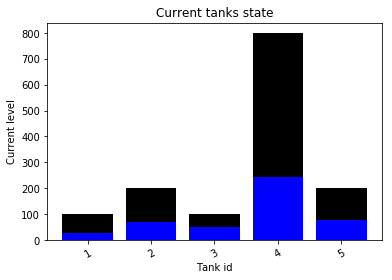

In [14]:
test_Q()
#print(np.mean(test_rewards_list) )

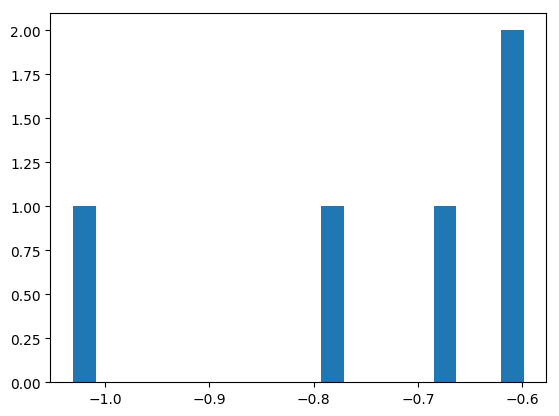

In [15]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

In [16]:
# Visualizing test simulation:

# test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
# HTML(test_anim.to_html5_video())


/home/user/envs/rl/lib/python3.5/site-packages/pandas/core/series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


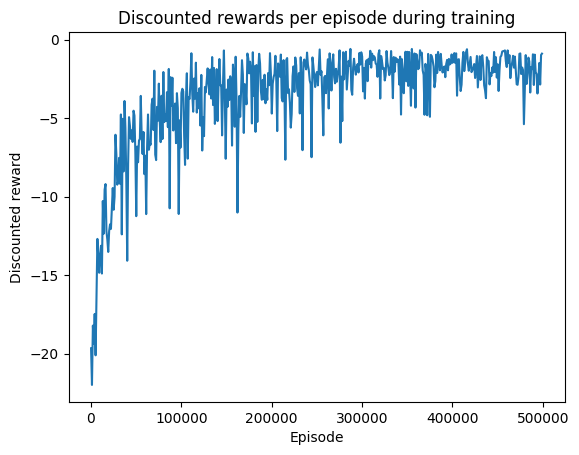

In [21]:
# Visualizing train simulation:

# episode =episodes
#simulation_id = 2
# step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

indices = [i for i in range(0,episodes,10)]

plt.plot(discrewards['episode'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")
plt.savefig(simulation_directory + '/discounted-rewards-sim' + '{}'.format(simulation_id) + '.pdf')

plt.show()
plt.close()


### Test visualization

In [13]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks
    
    def my_indicator(x_min, x, x_max):
            if (x> x_min) & (x<=x_max):
                return 1
            else: 
                return 0
    def is_empty(x):
        if x <=0:
            return 1
        else: 
            return 0
        
    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))
        ##################### Count number of times the system is in (0,b), (b,c),(c,e),(e,1) ##########
        b = percentages[0]
        level_counts = np.zeros(5, dtype = np.int64)
        
        x_mins = np.array([0,b,c,e])*tanks[i-1].max_load
        x_maxs = np.array([b,c,e,1])*tanks[i-1].max_load

        for x in states:
            level_counts[0] = level_counts[0] + is_empty(x)
            for j in range(1,5):
                level_counts[j] = level_counts[j] + my_indicator(x_mins[j-1], x, x_maxs[j-1])
            
        level_counts_list.append(level_counts)



    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [19]:

def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1,
                   noise = False):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(noise, seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = True

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
    test_number_of_first_trucks_sent_list = []
    test_number_of_second_trucks_sent_list = []
    test_number_of_trucks_not_deliverying_list = []
    
    test_level_counts_list = []
    
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list = test_number_of_first_trucks_sent_list,           
           number_of_second_trucks_sent_list=test_number_of_second_trucks_sent_list, 
           number_of_trucks_not_deliverying_list = test_number_of_trucks_not_deliverying_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        test_level_counts_list)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)

    #     if n_episodes == 1:
    first_type = sum(test_number_of_first_trucks_sent_list)/n_episodes
    print("Average 1st type Trucks sent to each shop:", first_type)
    print("Average 1st type Trucks sent:", sum(first_type[0:n] ) )

    second_type = sum(test_number_of_second_trucks_sent_list)/n_episodes
    print("Average 2nd type Trucks sent to each shop:", second_type)
    print("Average 2nd type Trucks sent:",  sum(second_type[0:n] ))

    print("Average number of trucks not deliverying:", sum(test_number_of_trucks_not_deliverying_list)/n_episodes )

    for i in range(n):
            print("Average level counts for shop {}:".format(i), test_level_counts_list[i]/n_episodes )


    print("Average total level counts:", sum(test_level_counts_list)/n_episodes )
    print("Percentage total level counts:", (sum(test_level_counts_list)/n_episodes)/(episode_length * n) * 100 )


    
test_episodes = 10

### Deterministic consumption rates without transport/unload costs, 0.5M episodes 

Test episode: 1
Episode 1 t 0 -1333.8216445 -1333.8216445 0.0 5500
Episode 1 t 1 -498.4153942 -498.4153942 0.0 5500
Episode 1 t 2 -858.0806194 -294.7068994 563.37372 4500
Episode 1 t 3 -550.7873265 -435.2234865 115.56384 0500
Episode 1 t 4 -1598.6972709 32.6101491 1631.30742 2400
Episode 1 t 5 27.1089953 27.1089953 0.0 5500
Episode 1 t 6 -158.7456652 -158.7456652 0.0 5500
Episode 1 t 7 -1359.9648467 -1359.9648467 0.0 5500
Episode 1 t 8 -2425.5047502 -1263.6754302 1161.82932 0400
Episode 1 t 9 -1458.2569894 -411.9915094 1046.26548 5300
Episode 1 t 10 -1079.0829594 -32.8174794 1046.26548 5300
Episode 1 t 11 -3020.7177934 -1389.4103734 1631.30742 2300
Episode 1 t 12 -1416.4277954 -254.5984754 1161.82932 0400
Episode 1 t 13 -16814.967855 -16240.760025 574.20783 1500
Episode 1 t 14 -2009.3138837 -963.0484037 1046.26548 5300
Episode 1 t 15 -2604.9777505 -1558.7122705 1046.26548 5300
Episode 1 t 16 -5080.6306126 -3918.8012926 1161.82932 0400
Episode 1 t 17 -2432.2919569 -800.9845369 1631.3074

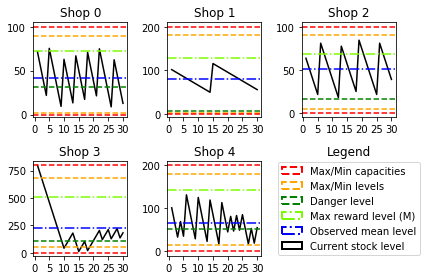

Total discounted rewards Level rewards Transport rewards
-16145.655513072668 -35730.78400857792 26982.60890999999
Average trucks sent:  37.0
Average 1st type Trucks sent to each shop: [ 7.  1.  4.  0.  6. 12.]
Average 1st type Trucks sent: 18.0
Average 2nd type Trucks sent to each shop: [ 0.  0.  0. 15.  4. 11.]
Average 2nd type Trucks sent: 19.0
Average number of trucks not deliverying: 0.0
Average level counts for shop 0: [ 0.  0. 11. 19.  0.]
Average level counts for shop 1: [ 0.  0.  0. 30.  0.]
Average level counts for shop 2: [ 0.  0.  0. 30.  0.]
Average level counts for shop 3: [ 0.  3.  5. 20.  2.]
Average level counts for shop 4: [ 0.  0. 12. 18.  0.]
Average total level counts: [  0.   3.  28. 117.   2.]
Percentage total level counts: [ 0.          2.         18.66666667 78.          1.33333333]


In [20]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes = 1)


Test episode: 1
Test episode: 2
Test episode: 3
Some tank is in a forbidden level
Some tank is in a forbidden level
Test episode: 4
Test episode: 5
Test episode: 6
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Some tank is in a forbidden level
Test episode: 7
Test episode: 8
Some tank is in a forbidden level
Some tank is in a forbidden level
Test episode: 9
Test episode: 10
Test episode: 11
Some tank is in a forbidden level
Test episode: 12
Test episode: 13
Test episode: 14
Some tank is in a forbidden level
Test episode: 15
Some tank is in a forbidden level
Test episode: 16
Some tank is in a forbidden level
Test episode: 17
Some tank is in a forbidden level
Some tank is in a forbidden level
Test episode: 18
Test episode: 19
Some tank is in a forbidden level
Some tank is in a forbidden level
Some t

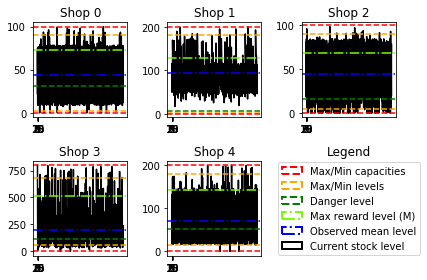

Total discounted rewards Level rewards Transport rewards
-210438.01889162522 -933838.418485682 29013.256465499988
Average trucks sent:  38.84
Average 1st type Trucks sent to each shop: [ 6.73  0.9   4.29  0.3   5.81 11.97]
Average 1st type Trucks sent: 18.03
Average 2nd type Trucks sent to each shop: [1.000e-02 1.100e-01 0.000e+00 1.645e+01 4.240e+00 9.190e+00]
Average 2nd type Trucks sent: 20.810000000000002
Average number of trucks not deliverying: 0.07
Average level counts for shop 0: [ 0.06  0.04  9.29 20.42  0.19]
Average level counts for shop 1: [ 0.   0.   0.  29.7  0.3]
Average level counts for shop 2: [ 0.75  0.45  1.94 26.75  0.11]
Average level counts for shop 3: [1.000e-02 9.000e-01 2.490e+00 2.627e+01 3.300e-01]
Average level counts for shop 4: [ 0.03  0.02 10.55 19.28  0.12]
Average total level counts: [  0.85   1.41  24.27 122.42   1.05]
Percentage total level counts: [ 0.56666667  0.94       16.18       81.61333333  0.7       ]


In [18]:
test_simulation(simulation_id=simulation_id, max_episodes = 5*10**5,n_episodes = 100)
